## RAG CON OLLAMA

Questo notebook costituisce un test di fattibilità riguardo l'utilizzo di un LLM "locale" per effettuare RAG (Retrieval Augmented Generation) partendo dal contenuto di un file pdf.

Per eseguire LLM in locale si utilizza OLLAMA (che deve essere installato sul PC) ed è necessario aver precedentemente scaricato un modello LLM da eseguire con Ollama.

Dal momento che il proxy aziendale non consente di scaricare automaticamente i modelli dal registry di Ollama, è possibile procedere scaricando manualmente i modelli in formato quantizato (GGUF) da Hugginface e poi renderli visibili da Ollama attraverso la configurazione di un Modelfile.

Per maggiori dettagli sull'utilizzo di GGUF con Ollama vedi transformers-course (Langchain_local_gguf.ipynb) e la bozza con le spiegazioni su come procedere (la dir di appoggio su win è C:\Users\axc0462\.ollama)

In questo esempio la comunicazione tra il notebook e Ollama avviene tramite il terminale (processo remoto)

In [206]:
#!pip install streamlit PyPDF2 langchain langchain-community spacy faiss-cpu
#!pip install https://github.com/explosion/spacy-models/releases/download/it_core_news_lg-3.7.0/it_core_news_lg-3.7.0.tar.gz
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1.tar.gz


In [207]:
import subprocess   # Consente di interagire con processi esterni (in questo caso Ollama)
#import streamlit as st
from PyPDF2 import PdfReader     # Lettura dei pdf

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings.spacy_embeddings import SpacyEmbeddings  # per generare embeddings utilizzando il modello di Spacy
from langchain_community.vectorstores import FAISS     # Importa il vector store dove memorizzare gli embbeddins
from langchain.tools.retriever import create_retriever_tool
from langchain_core.prompts import ChatPromptTemplate

import os
import re
import psutil

E' necessario settare a True il parametro sotto indicato per consentire a Faiss l'esecuzione di processi paralleli in fase di ricerca 

In [208]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

Definisco una funzione che estragga il testo dal/dai pdf forniti da parametro come lista di nomi di pdf.
La funzione utilizza PyPDF2 per estrarre il testo. <BR>
TODO : da implementare per pdf scanner

In [209]:
def pdf_read(pdf_doc):
    """Read the text from PDF document."""
    text = ""
    for pdf in pdf_doc:
        pdf_reader = PdfReader(pdf)
        for page in pdf_reader.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text
    return text

Utilizza la funzione precedente ricevendo in input la lista con il nome di un pdf per estrarre il testo contenuto

In [210]:
import os

#file_path = ['2023_-_SecAwareness_Training_-_Intro.pdf']
file_path = ['OFF-2024_0003AP_V1 - Alpitour.pdf']
text = pdf_read(file_path)
text

' \n 4Service Solution S.r.l. C.F. e P.IVA 04021010238 – REA VR-385038  T +39 045 4857.894- F +39 045 2050.221 E info@4servicesolution.it  VERONA - Sede legale, amministrativa e operativa Via Giovanni Pascoli, 4 37010 - Affi (VR)  \n    Riepilogo Licenze attive e  Progetto Alpitour  Canoni anno 2024                        Giovedì 28 dicembre 2023 \n  OFF-2024_0003AP_V1 - ALPITOUR.DOC 3  1. Servizi di manutenzione, assistenza e supporto 4Service Solution mette a disposizione dei propri clienti un pacchetto completo di servizi per la manutenzione, assistenza e supporto sui propri sistemi durante le fasi di start-up e lungo tutto il periodo contrattuale.   La proposta comprende i seguenti servizi: § Manutenzione evolutiva sulle licenze software § Manutenzione applicativa sul progetto implementato § Assistenza e supporto tramite il portale web di Help Desk e Trouble Ticketing Il costo annuale del Servizio di manutenzione evolutiva è pari al 20% del valore di listino delle licenze software 

Definisco una funzione per suddividere il testo estratto dal/dai PDF in chunks.<br>
La dimensione dei chunks e l'overlap è definito da parametro. Grazie alla suddivisione in chunks è possibile:
- controllare la dimensione dell'input passato all'LLM
- ottimizzare la successiva fase di ricerca (maggiore granularità fornisce risultati più accurati e ottimizza la velocità di esecuzione

In [211]:
def create_text_chunks(text, chunk_size=500, chunk_overlap=100):
    """Create text chunks from a large text block."""
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    text_chunks = text_splitter.split_text(text)
    return text_chunks

A scopo di test visualizzo i chunks creati- e il numero degli stessi

In [212]:
chunks = create_text_chunks(text)
chunks

['4Service Solution S.r.l. C.F. e P.IVA 04021010238 – REA VR-385038  T +39 045 4857.894- F +39 045 2050.221 E info@4servicesolution.it  VERONA - Sede legale, amministrativa e operativa Via Giovanni Pascoli, 4 37010 - Affi (VR)  \n    Riepilogo Licenze attive e  Progetto Alpitour  Canoni anno 2024                        Giovedì 28 dicembre 2023',
 'OFF-2024_0003AP_V1 - ALPITOUR.DOC 3  1. Servizi di manutenzione, assistenza e supporto 4Service Solution mette a disposizione dei propri clienti un pacchetto completo di servizi per la manutenzione, assistenza e supporto sui propri sistemi durante le fasi di start-up e lungo tutto il periodo contrattuale.   La proposta comprende i seguenti servizi: § Manutenzione evolutiva sulle licenze software § Manutenzione applicativa sul progetto implementato § Assistenza e supporto tramite il portale',
 '§ Manutenzione applicativa sul progetto implementato § Assistenza e supporto tramite il portale web di Help Desk e Trouble Ticketing Il costo annuale d

In [213]:
len(chunks)

26

Utilizzando lo Spacy model precedentemente caricato (per la lingua inglese, da testare per italiano!!!!) creo l'oggetto che dovrà occuparsi di vettorizzare il testo presente nei chunks nei rispettivi text embedding al fine di memorizzarli all'interno del vector store per poter poi essere utilizzati per effettuare "semantic search".

Questi vettori catturano il significato e il contesto del testo (frasi e parole) e lo traducono su uno spazio matematicamente interpretabile. 

In [214]:
embedder= SpacyEmbeddings(model_name="it_core_news_sm")
#embedder = SpacyEmbeddings(model_name="en_core_web_sm")

A scopo di test visualizzo gli embeddings creati- e il numero degli stessi

In [215]:
embeddings = embedder.embed_documents(chunks)
for i, embedding in enumerate(embeddings):
    print(f"Embedding for document {i+1}: {embedding}")

Embedding for document 1: [0.004692136310040951, 0.7582834959030151, 0.3015494644641876, -1.0064318180084229, 1.0016659498214722, 2.07669734954834, 1.0630438327789307, 1.6961091756820679, 1.7015925645828247, -0.49555277824401855, 0.22146472334861755, -1.7458590269088745, -0.8470032811164856, -0.8330553770065308, 0.4200107455253601, 1.037903070449829, 0.06353060156106949, -1.1045212745666504, 2.225206136703491, -1.1165940761566162, 0.1904297173023224, -0.07513007521629333, 1.2905428409576416, 2.3581981658935547, -0.7084225416183472, -0.5053213834762573, 0.31955042481422424, -1.4923876523971558, 0.29312482476234436, 1.851930022239685, 1.3206331729888916, 0.31498080492019653, -0.07761470228433609, 1.5132533311843872, 1.1958080530166626, -0.4930543303489685, 0.24749203026294708, -0.19831468164920807, -0.23494845628738403, -1.5978959798812866, -1.8116363286972046, 1.9968531131744385, 0.8077059388160706, 2.664735794067383, 1.3095614910125732, 3.0575430393218994, 0.7067442536354065, -0.513886

In [216]:
len(embeddings)

26

Definisco la funzione che memorizza gli embeddings dei text chunks. La funzione riceve in input la lista dei chunks e il modello per embeddings.
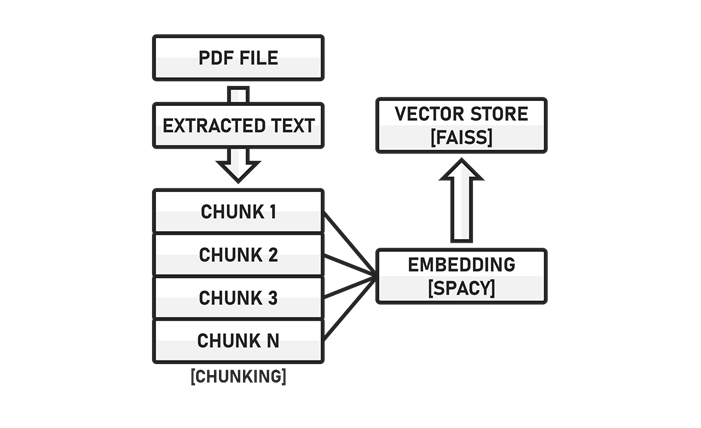
La memorizzazione viene effettuata su file sistem in locale

In [217]:
def vector_store(text_chunks):
    """Create a vector store for the text chunks."""
    vector_store = FAISS.from_texts(text_chunks, embedding=embedder)
    vector_store.save_local("faiss_db")

Per testare il corretto funzionamento della funzione, effettuo la chiamata per generare e memorizzare gli embeddings su vector database FAISS (in locale).

Una volta concluso il test sarà necessario cancellare la diretory dal file system in quanto la funzione verrà poi invocata a runtime.

In [218]:
vector_store(chunks)

Per verificare che l'archiviazione sia avvenuta con successo provo a ricreare un nuovo vector store FAISS partendo da quello salvato su file system e utilizzo questo nuovo vectore store per fare una similarity search con una frase di test.

In [219]:
new_vector_store = FAISS.load_local(
    "faiss_db", embedder, allow_dangerous_deserialization=True
)

results = new_vector_store.similarity_search_with_score(
    "Come vengono conteggiati gli interventi on site?",
    k=3
)

for res,score in results:
    print(f"* [SIM={score:3f}] {res.page_content} [{res.metadata}]")

* [SIM=112.253494] durante il normale orario di lavoro, dalle 9:00 alle 13:00 e dalle 14:00 alle 18:00, dal lunedì al venerdì, escluse le festività.  Interventi e/o reperibilità telefonica fuori orario lavorativo, oppure in giorni non feriali, saranno possibili con preavviso e a tariffe da concordare. 1.3.3. Durata degli interventi Gli interventi On-site sono conteggiati a giornate intere non frazionabili. Gli interventi effettuati telefonicamente o via remoto sono da considerarsi a tutti gli effetti attività [{}]
* [SIM=128.239243] utenti nel portale di ticketing per l’apertura di richieste di assistenza e l’interruzione degli aggiornamenti delle soluzioni installate. Qualora, a seguito di interruzione, il cliente desiderasse riattivare i servizi di assistenza e manutenzione, sarà necessario il riconoscimento di tutti gli eventuali canoni di manutenzione e assistenza pregressi. 3. Adeguamento ISTAT Le tariffe esposte saranno aggiornate annualmente utilizzando come riferimenti gli indi

In [220]:
#contesto = "It's important to note that this training is not optional. It's a mandatory requirement for all. Throughout the training, you will find recommendations on several security best practices."
contesto = ""
for res, _ in results:
    contesto += res.page_content
print(contesto)

durante il normale orario di lavoro, dalle 9:00 alle 13:00 e dalle 14:00 alle 18:00, dal lunedì al venerdì, escluse le festività.  Interventi e/o reperibilità telefonica fuori orario lavorativo, oppure in giorni non feriali, saranno possibili con preavviso e a tariffe da concordare. 1.3.3. Durata degli interventi Gli interventi On-site sono conteggiati a giornate intere non frazionabili. Gli interventi effettuati telefonicamente o via remoto sono da considerarsi a tutti gli effetti attivitàutenti nel portale di ticketing per l’apertura di richieste di assistenza e l’interruzione degli aggiornamenti delle soluzioni installate. Qualora, a seguito di interruzione, il cliente desiderasse riattivare i servizi di assistenza e manutenzione, sarà necessario il riconoscimento di tutti gli eventuali canoni di manutenzione e assistenza pregressi. 3. Adeguamento ISTAT Le tariffe esposte saranno aggiornate annualmente utilizzando come riferimenti gli indici istituzionali forniti dall’ISTATogni atti

Cancello la directory locale del DB in quanto verrà successivamente ri-creata

In [221]:
import shutil

shutil.rmtree("faiss_db")

Definisco la funzione per consentire la comunicazione con il processo esterno che esegue Ollama. La comunicazione avviene utilzizando stdin e stdout

In [222]:
def query_llama_via_cli(input_text):
    """Query the Llama model via the CLI."""
    try:
        # Start the interactive process
        process = subprocess.Popen(
#            ["ollama", "run", "myMistral"],
            ["ollama", "run", "llama31-ita"],
            stdin=subprocess.PIPE,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,  # Ensure that communication takes place as text (UTF-8)
            encoding='utf-8',  # Set UTF-8 encoding explicitly
            errors='ignore',  # Ignore incorrect characters
            bufsize=1
        )
        
        print(input_text)
        # Send the input to the process
        stdout, stderr = process.communicate(input=f"{input_text}\n", timeout=300)
        # Check error output
        if process.returncode != 0:
            return f"Error in the model request: {stderr.strip()}"

        # Filter response and remove control characters
        response = re.sub(r'\x1b\[.*?m', '', stdout)  # Remove ANSI codes

        # Extract the relevant answer
        return extract_relevant_answer(response)

    except subprocess.TimeoutExpired:
        process.kill()
        return "Timeout for the model request"
    except Exception as e:
        return f"An unexpected error has occurred: {str(e)}"


Funzione che filtra la risposta dell'LLM per rimuovere i caratteri di controllo. A questo punto si potrebbero prevedere anche ulteriori filtri per estrarre pattern più specifici

In [223]:
def extract_relevant_answer(full_response):
    """Extract the relevant response from the full model response."""
    response_lines = full_response.splitlines()

    # Search for the relevant answer; if there is a marker, it can be used here
    if response_lines:
        # Assume that the answer comes as a complete return to be filtered
        return "\n".join(response_lines).strip()

    return "No answer received"


La funzione prepara l'input per LLM combinando il prompt e il context con la question dell'utente

In [224]:
def get_conversational_chain(context, ques):
    """Create the input for the model based on the prompt and context."""
    # Define the prompt behavior
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",

#                """You are an intelligent and helpful assistant. Your goal is to provide the most accurate and detailed answers 
#                possible to any question you receive. Use all available context to enhance your answers, and explain complex 
#                concepts in a simple manner. If additional information might help, suggest further areas for exploration. If the 
#                answer is not available in the provided context, state this clearly and offer related insights when possible.""",
                """Sei un assistente intelligente e disponibile. Il tuo obiettivo è fornire le risposte più precise e dettagliate 
                possibile a qualsiasi domanda che ricevi. Utilizza tutto il contesto disponibile per migliorare le tue risposte e spiegare quelle complesse 
                concetti in modo semplice. Se ulteriori informazioni potrebbero essere d'aiuto, suggerisci ulteriori aree da esplorare. Se il 
                la risposta non è disponibile nel contesto fornito, indicalo chiaramente e offri approfondimenti correlati quando possibile."""
            ),
            ("human", "{input}"),
            ("placeholder", "{agent_scratchpad}"),
        ]
    )

    # Combine the context and the question
    input_text = f"Prompt: {prompt.format(input=ques)}\nContext: {context}\nQuestion: {ques}"
    
    # Request to the model
    response = query_llama_via_cli(input_text)
    print(response)
    #st.write("PDF: ", response)  # The answer is displayed here


In [225]:
def user_input(user_question, pdf_text):
    """Processes the user input and calls up the model."""
    # Use the entire text of the PDF as context
    context = pdf_text

    # Configure and request
    get_conversational_chain(context, user_question)


In [226]:
user_question = "Come vengono conteggiati gli interventi on site?"
#user_question = "Is this training optional?"
pdf_text = contesto
 
user_input(user_question, pdf_text)

# Monitor RAM consumption
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Conversion to megabytes

print(f"Memory usage: {memory_usage:.2f} MB")

Prompt: System: Sei un assistente intelligente e disponibile. Il tuo obiettivo è fornire le risposte più precise e dettagliate 
                possibile a qualsiasi domanda che ricevi. Utilizza tutto il contesto disponibile per migliorare le tue risposte e spiegare quelle complesse 
                concetti in modo semplice. Se ulteriori informazioni potrebbero essere d'aiuto, suggerisci ulteriori aree da esplorare. Se il 
                la risposta non è disponibile nel contesto fornito, indicalo chiaramente e offri approfondimenti correlati quando possibile.
Human: Come vengono conteggiati gli interventi on site?
Context: durante il normale orario di lavoro, dalle 9:00 alle 13:00 e dalle 14:00 alle 18:00, dal lunedì al venerdì, escluse le festività.  Interventi e/o reperibilità telefonica fuori orario lavorativo, oppure in giorni non feriali, saranno possibili con preavviso e a tariffe da concordare. 1.3.3. Durata degli interventi Gli interventi On-site sono conteggiati a giornate 